In [143]:
from __future__ import annotations

import numpy as np
import cv2
from PIL import Image, ImageFilter
from skimage.transform import (hough_line, hough_line_peaks, hough_circle, hough_circle_peaks)
from skimage.draw import circle_perimeter
from skimage.feature import canny
from skimage.data import astronaut
from skimage.io import imread, imsave
from skimage.color import rgb2gray, gray2rgb, label2rgb
from skimage import img_as_float
from skimage.morphology import skeletonize
from skimage import data, img_as_float
from skimage.exposure import cumulative_distribution
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.filters import sobel, threshold_otsu
from skimage.feature import canny
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries, find_boundaries
from matplotlib import pylab as pylab

from tqdm import tqdm

1) Image Loading and Display (5 points)

- Load provided sample image;
- Complete histogram matching using helper image;
- Make additional transformations if needed;
- Calculate and plot the histogram of the image.

-----
**Histogram matching:**

Is another technique for adjusting the contrast of the image by means of another image. 
One need to calculate cumulative distribution function (cdf) of the image in order to complete histogram matching, for this use cumulative_distribution from skimage.exposure. 

https://paulbourke.net/miscellaneous/equalisation/

In [144]:
# cumulative histogram for construction of histogram matching
def cdf(im: np.array) -> np.array:
    '''
    computes the CDF of an image im as 2D numpy ndarray
    '''
    # your code here
    hist, _ = np.histogram(im, bins = 256, range=(0,256))
    return hist.cumsum()

# function for histogram matching
def hist_matching(c, c_t, im):
    '''
    c: CDF of input image computed with the function cdf()
    c_t: CDF of template image computed with the function cdf()
    im: input image as 2D numpy ndarray
    returns the modified pixel values for the input image
    '''
    # find closest pixel-matches corresponding to the CDF of the input image, given the value of the CDF H of
    # the template image at the corresponding pixels. Use numpy.interp()
    # your code here
    c = c / np.max(c)
    c_t = c_t / np.max(c_t)
    interp_val = np.interp(c, c_t, np.arange(0,256))
    return interp_val[im.flatten()].reshape(im.shape).astype("uint8")

'''
code reference: skimage.exposure.histogram_matching
https://github.com/scikit-image/scikit-image/blob/v0.21.0/skimage/exposure/histogram_matching.py#L34-L90
'''

In [148]:
img_test = cv2.imread('low_contrast_image.jpg', 0)

im_for_match = np.load('im_for_match.npy')

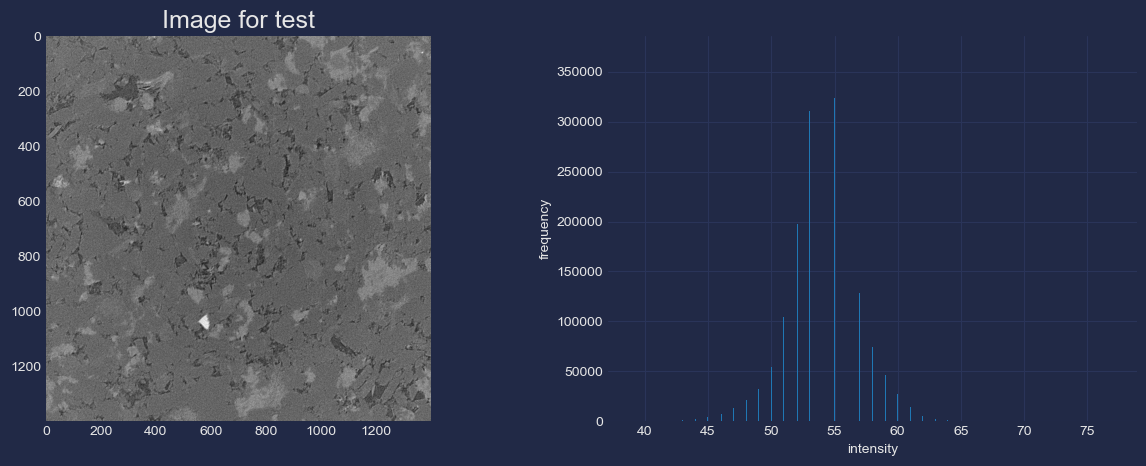

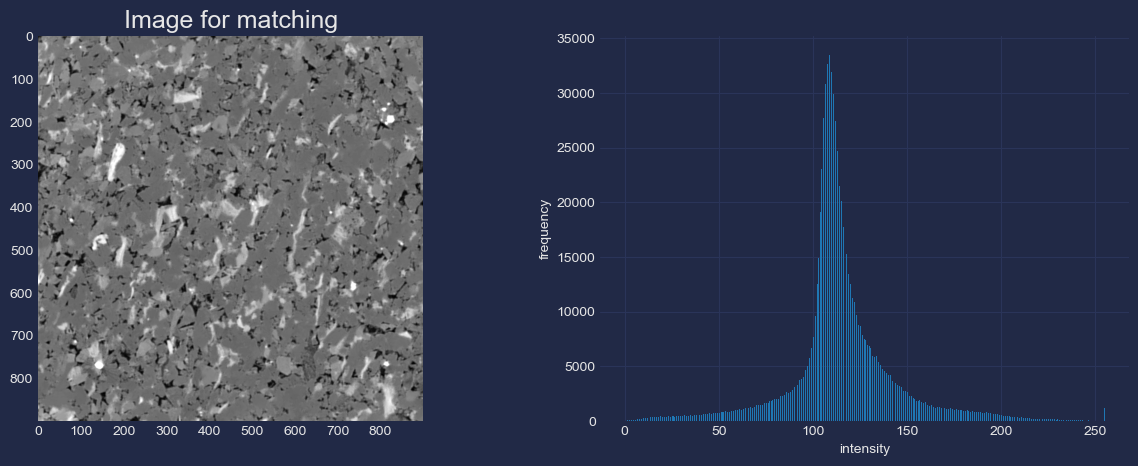

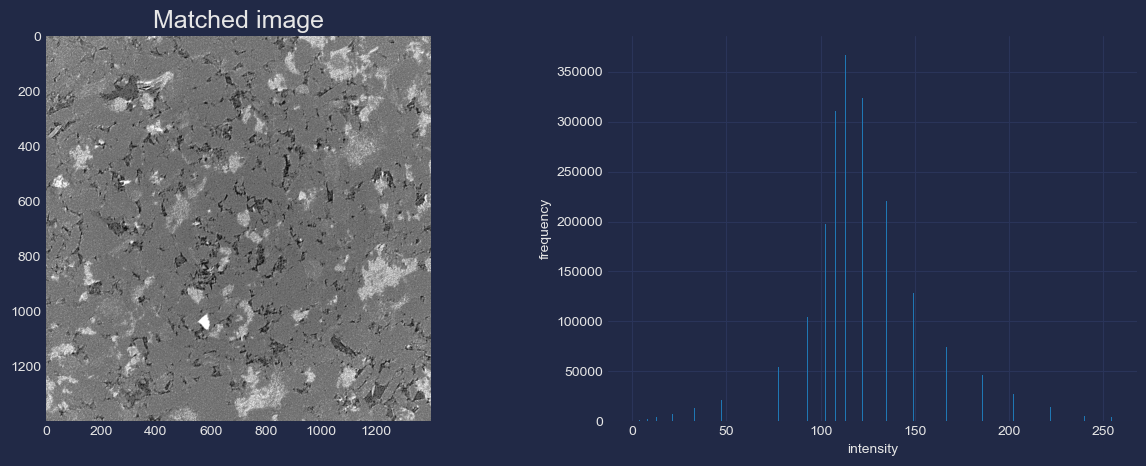

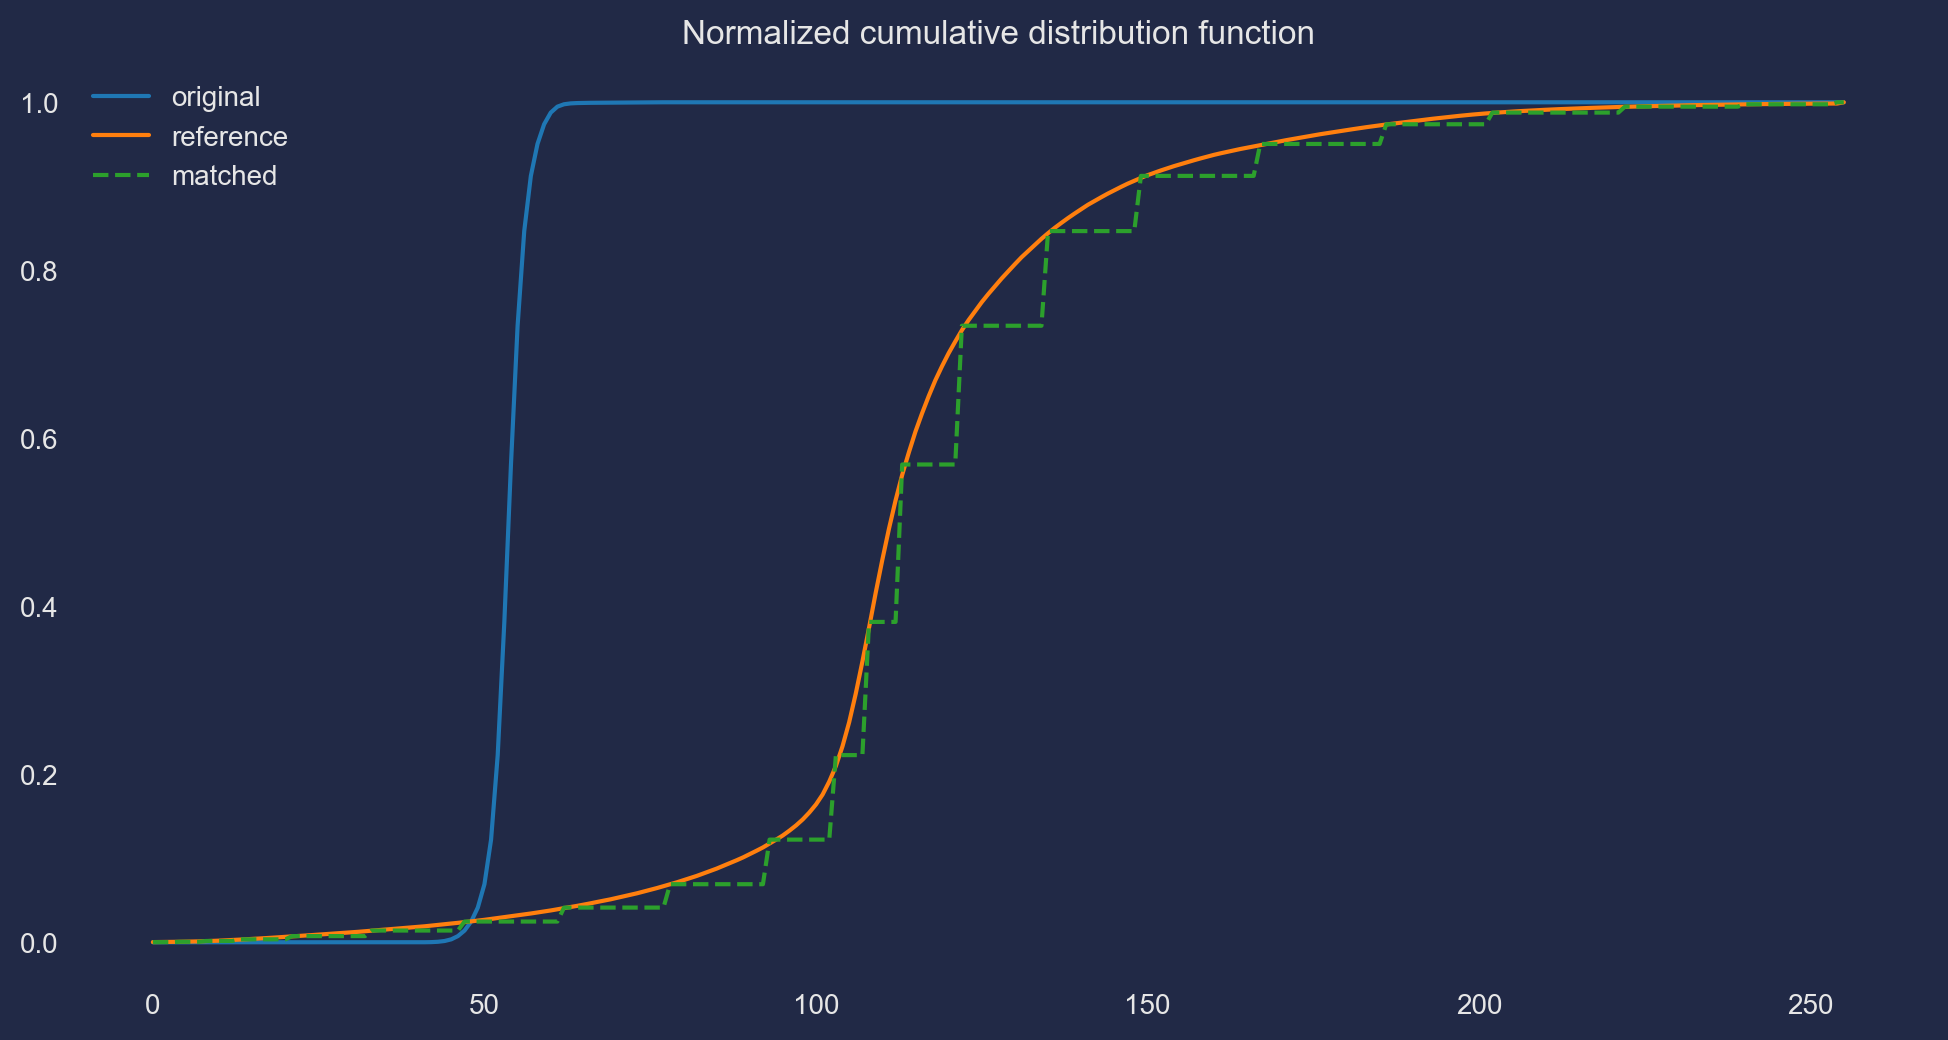

In [163]:
# use function from previous homework and plot histogram
def plot_hist(img):
    # your code here
    plt.hist(np.array(img).ravel(), bins=500)
    plt.grid(True, color='#2A3459')
    plt.ylabel('frequency')
    plt.xlabel('intensity')
    plt.show()

def plot_img_and_hist(img, img_name=''):
    pylab.style.use('seaborn-dark')
    for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
        plt.rcParams[param] = '#212946'
    for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
        plt.rcParams[param] = '0.9'

    pylab.figure(figsize=(15,5))
    pylab.subplot(121), pylab.imshow(img, cmap='gray'), pylab.title(img_name, size=18), pylab.grid(False)
    pylab.subplot(122), plot_hist(img), # pylab.yscale('log',basey=10)
    pylab.show()

plot_img_and_hist(img_test, 'Image for test')
plot_img_and_hist(im_for_match,'Image for matching')

im_matched = hist_matching(cdf(img_test), cdf(im_for_match), img_test)
plot_img_and_hist(im_matched, 'Matched image')

plt.figure(dpi = 200, figsize=(12,6))
plt.plot(cdf(img_test) / np.max(cdf(img_test) ), label = 'original')
plt.plot(cdf(im_for_match) / np.max(cdf(im_for_match)), label = 'reference')
plt.plot(cdf(im_matched) / np.max(cdf(im_matched)), label = 'matched', ls = '--')
plt.legend()
plt.title('Normalized cumulative distribution function')
plt.show()

2) Global/Local Otsu thersholding (10 points)

- Apply global thresholding and visualize the result (image, thresholded image, histogram)
- Apply local thresholding and visualize the result 
- Calculate the porosity for each segmentation method.

For global Otsu thresholding you may use skimage.filters or opencv libraries.

https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

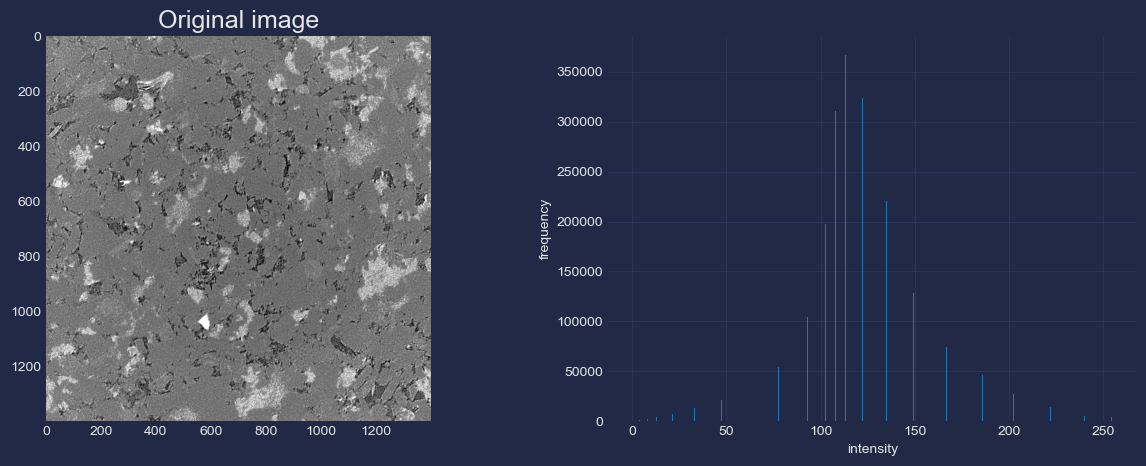

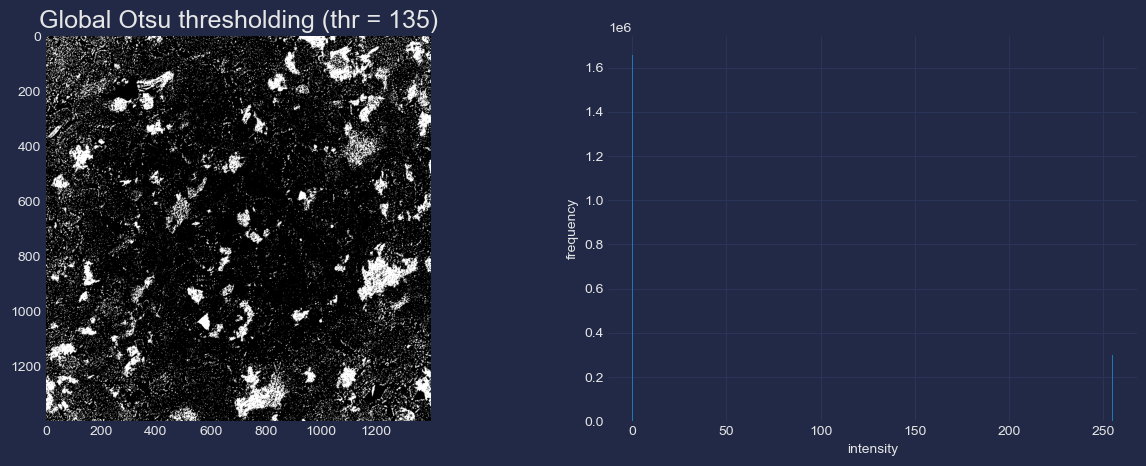

In [150]:
thr = threshold_otsu(im_matched)
plot_img_and_hist(im_matched, 'Original image')
global_thresholded = np.where(im_matched > thr, 255, 0)
plot_img_and_hist(global_thresholded, f'Global Otsu thresholding (thr = {int(thr)})')

Local Otsu thresholding: 

you need calculate Otsu Threshold for each pixel individually with moving window with given size

In [151]:
# this is a simplified function which doesnt take into account edge values (you may apply padding) 
def local_otsu(image, window_size):
    """
    Calculate local Otsu thresholding for an image.

    This function applies a local Otsu thresholding algorithm to the input image using a specified
    window size. The result is a binary image with threshold values determined locally around each pixel.

    Args:
        image (numpy.ndarray): The input grayscale image.
        window_size (int): The size of the local window for thresholding.

    Returns:
        Tuple[float, numpy.ndarray]: A tuple containing the global Otsu threshold value and the
        thresholded binary image.
    """
    # Your code here
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='constant')

    height, width = image.shape[:2]
    binary_image = np.zeros((height, width), dtype=np.uint8)

    for y in tqdm(range(height)):
        for x in range(width):
            window = padded_image[y:y+window_size, x:x+window_size]
            threshold = threshold_otsu(window)
            binary_image[y, x] = window[window_size // 2, window_size // 2] > threshold

    global_threshold = threshold_otsu(image)

    return global_threshold, np.where(binary_image, 255, 0)

100%|██████████| 1400/1400 [11:18<00:00,  2.06it/s]


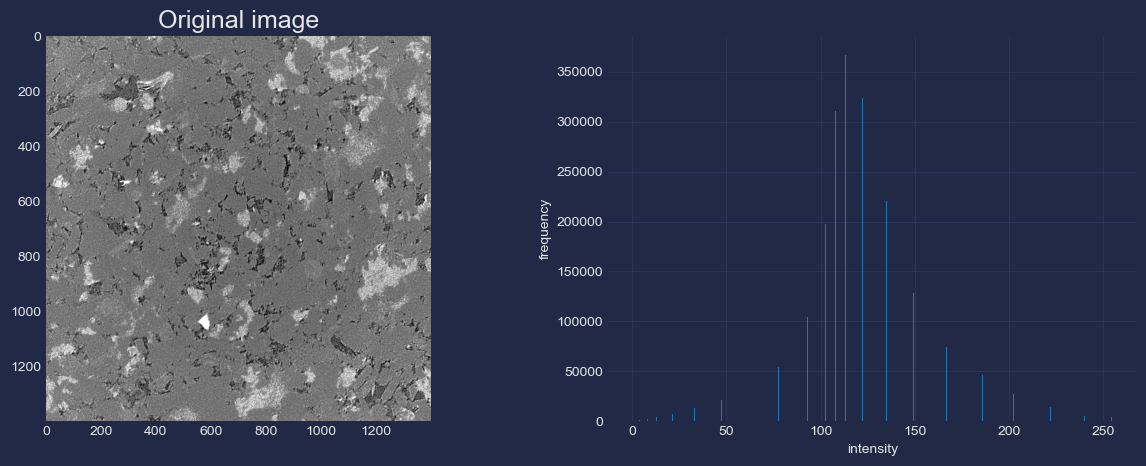

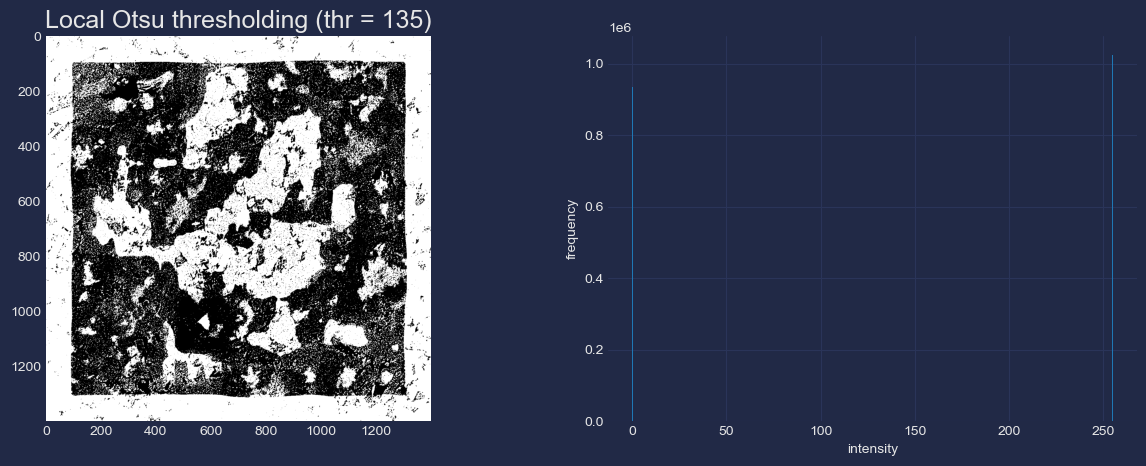

In [153]:
thr, local_thresholded =  local_otsu(im_matched, 200)
plot_img_and_hist(im_matched, 'Original image')
plot_img_and_hist(local_thresholded, f'Local Otsu thresholding (thr = {int(thr)})')

**Porosity calculation:**

for calculation of porosity you work with binary image and calculates the fraction of pores, i.e. pixels with value 1 among all pixels. 

In [154]:
def porosity_calculation(im: np.array, vis: bool = True) -> float:
    phi = 1 - np.count_nonzero(im)/im.size
    if vis:
        print(f'Porosity equals {phi}')
    return phi

_ = porosity_calculation(global_thresholded)
_ = porosity_calculation(local_thresholded)

Porosity equals 0.8466505102040817
Porosity equals 0.47673877551020405
